# TME6 PPO

In [1]:
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
from utils_rdl import smooth

import numpy as np
import random
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter

matplotlib.use("TkAgg")

import gym
import gridworld
from gym import wrappers, logger

import io
import base64
from IPython.display import HTML


Using matplotlib backend: Qt5Agg


In [2]:
from utils_rdl import NN, AleaStock, MultiInputNN, Orn_Uhlen
from utils_rdl import play_one_run, train_agent
from utils_rdl import GridWorldMethods, GridWorldFeaturesMethods, CartPoleDiscreteMethods, LunarLanderDiscreteMethods
from utils_rdl import MountainCarContinuousMethods, PendulumContinuousMethods, LunarLanderContinuousMethods
from utils_rdl import BaseAgent, BaseMemAgent, BaseBatchEpisodeAgent


## Agents

In [3]:
class BasePPOAgent(BaseBatchEpisodeAgent):
    def __init__(self, action_space, obs0, gamma=.9, layers_V=[20,20], layers_pi=[20,20], lr_pi=.01, lr_V=.01, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.action_space = action_space

        self.gamma = gamma
    
        inSize = self.Phi(obs0).shape[-1]
        outSize = action_space.n
        self.V  = NN(inSize, 1,       layers_V)
        self.pi      = NN(inSize, outSize, layers_pi)
        self.optimizer_V  = torch.optim.Adam(params=self.V .parameters(), lr=lr_V)
        self.optimizer_pi = torch.optim.Adam(params=self.pi.parameters(), lr=lr_pi)
        self.loss_fun_V = nn.SmoothL1Loss(reduction='sum')

        self.step = 0

    def act(self, s2):
        with torch.no_grad():
            a1 = torch.multinomial(torch.softmax(self.pi(torch.from_numpy(s2).view(1,-1)), dim=-1).view(-1), num_samples=1).item()
        return a1

    def update(self, batch):
        s1, a, r, s2, d = batch
        ## compute advantage using the A2C algo
        with torch.no_grad():
            target_V = torch.zeros(len(r), dtype=s2.dtype)
            target_V[-1] = r[-1]
            for i in range(len(r)-1, 0, -1):
                target_V[i-1] = target_V[i] + r[i-1]
        self.optimizer_V.zero_grad()
        self.V.train()
        loss_V = self.loss_fun_V(self.V(s2), target_V.view(-1,1))
        loss_V.backward()
        self.optimizer_V.step()
        # compute advantage :
        with torch.no_grad():
            A = r.view(-1,1) + self.gamma*self.V(s2) - self.V(s1)
        self.update_policy(batch, A)
        
    def update_policy(self, batch, A):
        raise NotImplementedError

    
class KL_PPOAgent(BasePPOAgent):
    def __init__(self, K=3, delta=.5, initial_penalty=1., *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.K = K
        self.beta = initial_penalty
        self.delta = delta ## KL divergence
        self.log_dict['loss_pi'] = []
        self.log_dict['loss_kl'] = []
        self.log_dict['loss'] = []
    def update_policy(self, batch, A):
        s1, a, r, s2, d = batch
        with torch.no_grad():
            distrib_0 = torch.softmax(self.pi(s1), dim=-1)
            distrib_0_gathered = torch.gather(distrib_0, 1, a.view(-1,1))
        self.pi.train()
        for i in range(self.K):
            self.optimizer_pi.zero_grad()
            distrib = torch.softmax(self.pi(s1), dim=-1)
            distrib_gathered = torch.gather(distrib, 1, a.view(-1,1))
            rapport = distrib_gathered/distrib_0_gathered
            loss_pi = torch.sum(rapport * A)
            loss_kl = F.kl_div(distrib.log(), distrib_0)
            loss = -(loss_pi - self.beta*loss_kl)
            loss.backward()
            self.optimizer_pi.step()
            self.log_dict['loss_pi'].append((self.step, -loss_pi.item()))
            self.log_dict['loss_kl'].append((self.step, loss_kl.item()))
            self.log_dict['loss'].append((self.step, loss.item()))
            self.step += 1
        
        with torch.no_grad():
            log_distrib = torch.log_softmax(self.pi(s1), dim=-1)
            dist =  F.kl_div(log_distrib, distrib_0) 
        if dist>= 1.5*self.delta:
            self.beta *= 2.
        elif dist<=self.delta/1.5:
            self.beta /= 2.
            
            
class ClippedPPOAgent(BasePPOAgent):
    def __init__(self, K=3, eps=.01, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eps = eps
        self.K = K
        self.log_dict['loss'] = []
    def update_policy(self, batch, A):
        s1, a, r, s2, d = batch
        with torch.no_grad():
            distrib_0 = torch.softmax(self.pi(s1), dim=-1)
            distrib_0_gathered = torch.gather(distrib_0, 1, a.view(-1,1))
        self.pi.train()
        for i in range(self.K):
            self.optimizer_pi.zero_grad()
            distrib = torch.softmax(self.pi(s1), dim=-1)
            distrib_gathered = torch.gather(distrib, 1, a.view(-1,1))
            rapport = distrib_gathered/distrib_0_gathered
            loss = - torch.sum(torch.min(torch.stack([rapport*A, torch.clamp(rapport, 1-eps, 1+eps)*A], axis=-1), axis=-1).values)
            loss.backward()
            self.optimizer_pi.step()
            self.log_dict['loss'].append((self.step, loss.item()))
            self.step += 1
            
            

>> Lors du premier passage, la divergence KL est nulle car les 2 distributions sont identiques

## Cartpole

In [4]:
env_methods = CartPoleDiscreteMethods()
env = gym.make(env_methods.get_env_name())
# env = gym.make('CartPole-v1')


env_name = 'CartPole-v1'


In [13]:
## KL PPO

gamma = .9999

layers_pi = [20, 20]
layers_V  = [20, 20]
lr_pi = 1e-3
lr_V  = 1e-2

K = 10
initial_penalty = 10
delta = .001

obs0 = env.reset()
agent = KL_PPOAgent(
    action_space=env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi,
    gamma=gamma,
    initial_penalty=initial_penalty, K=K, delta=delta,
    env_methods=env_methods,
    )


out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=500)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=12	DONE    	rsum=12.0
Episode 2	num_iter=11	DONE    	rsum=11.0
Episode 3	num_iter=17	DONE    	rsum=17.0
Episode 4	num_iter=32	DONE    	rsum=32.0
Episode 5	num_iter=20	DONE    	rsum=20.0
Episode 6	num_iter=12	DONE    	rsum=12.0
Episode 7	num_iter=27	DONE    	rsum=27.0
Episode 8	num_iter=17	DONE    	rsum=17.0
Episode 9	num_iter=25	DONE    	rsum=25.0
Episode 10	num_iter=13	DONE    	rsum=13.0
Episode 11	num_iter=12	DONE    	rsum=12.0
Episode 12	num_iter=17	DONE    	rsum=17.0
Episode 13	num_iter=15	DONE    	rsum=15.0
Episode 14	num_iter=15	DONE    	rsum=15.0
Episode 15	num_iter=19	DONE    	rsum=19.0
Episode 16	num_iter=33	DONE    	rsum=33.0
Episode 17	num_iter=9	DONE    	rsum=9.0
Episode 18	num_iter=18	DONE    	rsum=18.0
Episode 19	num_iter=25	DONE    	rsum=25.0
Episode 20	num_iter=14	DONE    	rsum=14.0
Episode 21	num_iter=12	DONE    	rsum=12.0
Episode 22	num_iter=15	DONE    	rsum=15.0
Episode 23	num_iter=25	DONE    	rsum=25.0
Episode 24	num_iter=44	DONE    	rsum=44.0
Epi

Episode 203	num_iter=49	DONE    	rsum=49.0
Episode 204	num_iter=51	DONE    	rsum=51.0
Episode 205	num_iter=48	DONE    	rsum=48.0
Episode 206	num_iter=59	DONE    	rsum=59.0
Episode 207	num_iter=56	DONE    	rsum=56.0
Episode 208	num_iter=50	DONE    	rsum=50.0
Episode 209	num_iter=52	DONE    	rsum=52.0
Episode 210	num_iter=67	DONE    	rsum=67.0
Episode 211	num_iter=74	DONE    	rsum=74.0
Episode 212	num_iter=57	DONE    	rsum=57.0
Episode 213	num_iter=97	DONE    	rsum=97.0
Episode 214	num_iter=90	DONE    	rsum=90.0
Episode 215	num_iter=70	DONE    	rsum=70.0
Episode 216	num_iter=111	DONE    	rsum=111.0
Episode 217	num_iter=112	DONE    	rsum=112.0
Episode 218	num_iter=73	DONE    	rsum=73.0
Episode 219	num_iter=106	DONE    	rsum=106.0
Episode 220	num_iter=118	DONE    	rsum=118.0
Episode 221	num_iter=92	DONE    	rsum=92.0
Episode 222	num_iter=179	DONE    	rsum=179.0
Episode 223	num_iter=135	DONE    	rsum=135.0
Episode 224	num_iter=249	DONE    	rsum=249.0
Episode 225	num_iter=151	DONE    	rsum=1

Episode 396	num_iter=122	DONE    	rsum=122.0
Episode 397	num_iter=128	DONE    	rsum=128.0
Episode 398	num_iter=121	DONE    	rsum=121.0
Episode 399	num_iter=189	DONE    	rsum=189.0
Episode 400	num_iter=195	DONE    	rsum=195.0
Episode 401	num_iter=127	DONE    	rsum=127.0
Episode 402	num_iter=203	DONE    	rsum=203.0
Episode 403	num_iter=182	DONE    	rsum=182.0
Episode 404	num_iter=264	DONE    	rsum=264.0
Episode 405	num_iter=191	DONE    	rsum=191.0
Episode 406	num_iter=213	DONE    	rsum=213.0
Episode 407	num_iter=500	MAX_ITER	rsum=500.0
Episode 408	num_iter=393	DONE    	rsum=393.0
Episode 409	num_iter=197	DONE    	rsum=197.0
Episode 410	num_iter=302	DONE    	rsum=302.0
Episode 411	num_iter=204	DONE    	rsum=204.0
Episode 412	num_iter=500	MAX_ITER	rsum=500.0
Episode 413	num_iter=162	DONE    	rsum=162.0
Episode 414	num_iter=214	DONE    	rsum=214.0
Episode 415	num_iter=382	DONE    	rsum=382.0
Episode 416	num_iter=500	MAX_ITER	rsum=500.0
Episode 417	num_iter=477	DONE    	rsum=477.0
Episode 41

(500.0, 500, True)

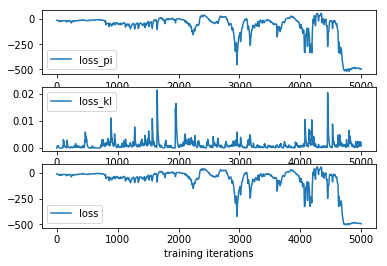

In [14]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.9))
    plt.grid()
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()




In [26]:
## Clipped PPO

gamma = .9999

layers_pi = [20, 20]
layers_V  = [20, 20]
lr_pi = 1e-3
lr_V  = 1e-2

K = 10
eps = .2

obs0 = env.reset()
agent = ClippedPPOAgent(
    action_space=env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi, lr_V=lr_V,
    gamma=gamma,
    K=K, eps=eps,
    env_methods=env_methods,
)




out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=500)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=37	DONE    	rsum=37.0
Episode 2	num_iter=14	DONE    	rsum=14.0
Episode 3	num_iter=62	DONE    	rsum=62.0
Episode 4	num_iter=18	DONE    	rsum=18.0
Episode 5	num_iter=27	DONE    	rsum=27.0
Episode 6	num_iter=10	DONE    	rsum=10.0
Episode 7	num_iter=12	DONE    	rsum=12.0
Episode 8	num_iter=16	DONE    	rsum=16.0
Episode 9	num_iter=38	DONE    	rsum=38.0
Episode 10	num_iter=12	DONE    	rsum=12.0
Episode 11	num_iter=18	DONE    	rsum=18.0
Episode 12	num_iter=24	DONE    	rsum=24.0
Episode 13	num_iter=23	DONE    	rsum=23.0
Episode 14	num_iter=13	DONE    	rsum=13.0
Episode 15	num_iter=16	DONE    	rsum=16.0
Episode 16	num_iter=10	DONE    	rsum=10.0
Episode 17	num_iter=13	DONE    	rsum=13.0
Episode 18	num_iter=11	DONE    	rsum=11.0
Episode 19	num_iter=13	DONE    	rsum=13.0
Episode 20	num_iter=10	DONE    	rsum=10.0
Episode 21	num_iter=9	DONE    	rsum=9.0
Episode 22	num_iter=9	DONE    	rsum=9.0
Episode 23	num_iter=10	DONE    	rsum=10.0
Episode 24	num_iter=9	DONE    	rsum=9.0
Episode

Episode 207	num_iter=10	DONE    	rsum=10.0
Episode 208	num_iter=9	DONE    	rsum=9.0
Episode 209	num_iter=9	DONE    	rsum=9.0
Episode 210	num_iter=10	DONE    	rsum=10.0
Episode 211	num_iter=8	DONE    	rsum=8.0
Episode 212	num_iter=9	DONE    	rsum=9.0
Episode 213	num_iter=10	DONE    	rsum=10.0
Episode 214	num_iter=8	DONE    	rsum=8.0
Episode 215	num_iter=9	DONE    	rsum=9.0
Episode 216	num_iter=8	DONE    	rsum=8.0
Episode 217	num_iter=9	DONE    	rsum=9.0
Episode 218	num_iter=9	DONE    	rsum=9.0
Episode 219	num_iter=9	DONE    	rsum=9.0
Episode 220	num_iter=10	DONE    	rsum=10.0
Episode 221	num_iter=8	DONE    	rsum=8.0
Episode 222	num_iter=11	DONE    	rsum=11.0
Episode 223	num_iter=10	DONE    	rsum=10.0
Episode 224	num_iter=8	DONE    	rsum=8.0
Episode 225	num_iter=10	DONE    	rsum=10.0
Episode 226	num_iter=9	DONE    	rsum=9.0
Episode 227	num_iter=8	DONE    	rsum=8.0
Episode 228	num_iter=8	DONE    	rsum=8.0
Episode 229	num_iter=9	DONE    	rsum=9.0
Episode 230	num_iter=9	DONE    	rsum=9.0
Ep

Episode 413	num_iter=9	DONE    	rsum=9.0
Episode 414	num_iter=10	DONE    	rsum=10.0
Episode 415	num_iter=9	DONE    	rsum=9.0
Episode 416	num_iter=9	DONE    	rsum=9.0
Episode 417	num_iter=10	DONE    	rsum=10.0
Episode 418	num_iter=8	DONE    	rsum=8.0
Episode 419	num_iter=9	DONE    	rsum=9.0
Episode 420	num_iter=11	DONE    	rsum=11.0
Episode 421	num_iter=10	DONE    	rsum=10.0
Episode 422	num_iter=12	DONE    	rsum=12.0
Episode 423	num_iter=8	DONE    	rsum=8.0
Episode 424	num_iter=9	DONE    	rsum=9.0
Episode 425	num_iter=10	DONE    	rsum=10.0
Episode 426	num_iter=10	DONE    	rsum=10.0
Episode 427	num_iter=16	DONE    	rsum=16.0
Episode 428	num_iter=9	DONE    	rsum=9.0
Episode 429	num_iter=15	DONE    	rsum=15.0
Episode 430	num_iter=9	DONE    	rsum=9.0
Episode 431	num_iter=34	DONE    	rsum=34.0
Episode 432	num_iter=25	DONE    	rsum=25.0
Episode 433	num_iter=27	DONE    	rsum=27.0
Episode 434	num_iter=16	DONE    	rsum=16.0
Episode 435	num_iter=19	DONE    	rsum=19.0
Episode 436	num_iter=14	DONE 

(86.0, 86, True)

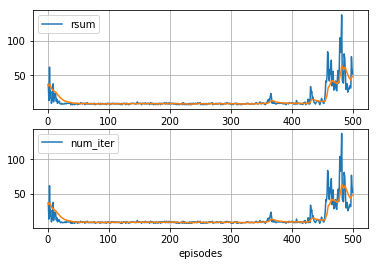

In [27]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.9))
    plt.grid()
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()




## LunarLander

In [51]:
env_methods = LunarLanderDiscreteMethods()
env = gym.make(env_methods.get_env_name())


env_name = 'LunarLander-v2'


In [33]:
## KL PPO

gamma = .9999

layers_pi = [20, 20]
layers_V  = [20, 20]
lr_pi = 1e-3
lr_V  = 1e-3

K = 10
initial_penalty = 10
delta = .005

obs0 = env.reset()
agent = KL_PPOAgent(
    action_space=env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi,
    gamma=gamma,
    initial_penalty=initial_penalty, K=K, delta=delta,
    env_methods=env_methods,
    )


out = train_agent(agent, env, max_iter=1000, verbose=1, num_episodes=1000)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=89	DONE    	rsum=-103.89690833119086
Episode 2	num_iter=92	DONE    	rsum=-208.0952768054075
Episode 3	num_iter=128	DONE    	rsum=-204.25965600102688
Episode 4	num_iter=107	DONE    	rsum=-63.09587490976473
Episode 5	num_iter=77	DONE    	rsum=-102.62731873325914
Episode 6	num_iter=121	DONE    	rsum=-332.51122557460656
Episode 7	num_iter=123	DONE    	rsum=-97.56858761151378
Episode 8	num_iter=125	DONE    	rsum=-314.10813009849437
Episode 9	num_iter=127	DONE    	rsum=-398.1929175738691
Episode 10	num_iter=89	DONE    	rsum=-376.2767856609023
Episode 11	num_iter=87	DONE    	rsum=-369.172538036957
Episode 12	num_iter=109	DONE    	rsum=-314.79741656135644
Episode 13	num_iter=77	DONE    	rsum=-255.86443915882523
Episode 14	num_iter=75	DONE    	rsum=-157.74668505787687
Episode 15	num_iter=171	DONE    	rsum=-248.33978200571792
Episode 16	num_iter=111	DONE    	rsum=-300.1252716105557
Episode 17	num_iter=118	DONE    	rsum=-462.6862198576092
Episode 18	num_iter=89	DONE    	rsum=-2

Episode 144	num_iter=228	DONE    	rsum=-84.1537031772326
Episode 145	num_iter=423	DONE    	rsum=-252.84858695524676
Episode 146	num_iter=303	DONE    	rsum=-18.17418383151373
Episode 147	num_iter=452	DONE    	rsum=-274.44669818244176
Episode 148	num_iter=1000	MAX_ITER	rsum=-24.17405843375398
Episode 149	num_iter=164	DONE    	rsum=-21.750982603346046
Episode 150	num_iter=364	DONE    	rsum=-210.4624323030987
Episode 151	num_iter=154	DONE    	rsum=-183.04559606861116
Episode 152	num_iter=223	DONE    	rsum=-194.07082079297945
Episode 153	num_iter=1000	MAX_ITER	rsum=-126.74966597680609
Episode 154	num_iter=1000	MAX_ITER	rsum=-109.42024236431948
Episode 155	num_iter=228	DONE    	rsum=-7.626815061611552
Episode 156	num_iter=264	DONE    	rsum=-86.53315179337764
Episode 157	num_iter=1000	MAX_ITER	rsum=-49.89689876274518
Episode 158	num_iter=218	DONE    	rsum=-161.01335057314594
Episode 159	num_iter=420	DONE    	rsum=-335.3893919746933
Episode 160	num_iter=182	DONE    	rsum=-69.26768111684648
Epi

Episode 285	num_iter=266	DONE    	rsum=-231.75646553483693
Episode 286	num_iter=190	DONE    	rsum=-19.470424082207927
Episode 287	num_iter=289	DONE    	rsum=-187.13454741369145
Episode 288	num_iter=1000	MAX_ITER	rsum=144.36337177315997
Episode 289	num_iter=293	DONE    	rsum=-232.55647534151163
Episode 290	num_iter=255	DONE    	rsum=-35.34800037851349
Episode 291	num_iter=440	DONE    	rsum=160.58400593577397
Episode 292	num_iter=351	DONE    	rsum=-84.41314424299196
Episode 293	num_iter=266	DONE    	rsum=-13.321240758190214
Episode 294	num_iter=176	DONE    	rsum=-56.50147204101752
Episode 295	num_iter=258	DONE    	rsum=-133.96643870757723
Episode 296	num_iter=1000	MAX_ITER	rsum=136.54698979373057
Episode 297	num_iter=242	DONE    	rsum=-21.412195651721987
Episode 298	num_iter=298	DONE    	rsum=-173.23705679780502
Episode 299	num_iter=179	DONE    	rsum=16.9724958704319
Episode 300	num_iter=371	DONE    	rsum=-232.047034076248
Episode 301	num_iter=311	DONE    	rsum=-101.56156109272644
Episod

Episode 426	num_iter=316	DONE    	rsum=-54.183753006744254
Episode 427	num_iter=293	DONE    	rsum=-81.88522030776744
Episode 428	num_iter=1000	MAX_ITER	rsum=97.23959439704534
Episode 429	num_iter=274	DONE    	rsum=-226.72837153787768
Episode 430	num_iter=237	DONE    	rsum=-40.41561783174066
Episode 431	num_iter=224	DONE    	rsum=43.00868962520997
Episode 432	num_iter=375	DONE    	rsum=-92.20088353506281
Episode 433	num_iter=341	DONE    	rsum=-201.51317434599366
Episode 434	num_iter=242	DONE    	rsum=-159.41876251062098
Episode 435	num_iter=246	DONE    	rsum=-21.228929375669452
Episode 436	num_iter=234	DONE    	rsum=-23.723662967295184
Episode 437	num_iter=284	DONE    	rsum=-227.17893140682955
Episode 438	num_iter=336	DONE    	rsum=-240.19496752619878
Episode 439	num_iter=438	DONE    	rsum=167.31646954835367
Episode 440	num_iter=1000	MAX_ITER	rsum=178.01558819037902
Episode 441	num_iter=234	DONE    	rsum=-7.926067753830978
Episode 442	num_iter=234	DONE    	rsum=-220.50779792272988
Episo

Episode 567	num_iter=201	DONE    	rsum=-174.03084140780413
Episode 568	num_iter=390	DONE    	rsum=247.49207294747882
Episode 569	num_iter=314	DONE    	rsum=-233.44760745436548
Episode 570	num_iter=1000	MAX_ITER	rsum=90.36394063675084
Episode 571	num_iter=352	DONE    	rsum=-70.6240872269374
Episode 572	num_iter=234	DONE    	rsum=4.576731768886432
Episode 573	num_iter=280	DONE    	rsum=-172.13040241617895
Episode 574	num_iter=227	DONE    	rsum=-177.22568948310953
Episode 575	num_iter=383	DONE    	rsum=-61.39631798054086
Episode 576	num_iter=277	DONE    	rsum=-95.61931178544094
Episode 577	num_iter=266	DONE    	rsum=-202.33607988407869
Episode 578	num_iter=168	DONE    	rsum=30.32810621166425
Episode 579	num_iter=274	DONE    	rsum=-21.37879198351719
Episode 580	num_iter=181	DONE    	rsum=-102.72313007534184
Episode 581	num_iter=269	DONE    	rsum=-206.04037457537163
Episode 582	num_iter=456	DONE    	rsum=223.60747031015507
Episode 583	num_iter=381	DONE    	rsum=-210.73354615505065
Episode 5

Episode 708	num_iter=370	DONE    	rsum=-45.910286802878076
Episode 709	num_iter=292	DONE    	rsum=-61.12240607684345
Episode 710	num_iter=377	DONE    	rsum=223.26925667535872
Episode 711	num_iter=312	DONE    	rsum=-227.18299030513367
Episode 712	num_iter=291	DONE    	rsum=-196.6583752307758
Episode 713	num_iter=278	DONE    	rsum=-41.58162792201095
Episode 714	num_iter=414	DONE    	rsum=229.24912487794924
Episode 715	num_iter=273	DONE    	rsum=273.94777584834037
Episode 716	num_iter=316	DONE    	rsum=259.7449692439719
Episode 717	num_iter=235	DONE    	rsum=31.35253593215336
Episode 718	num_iter=252	DONE    	rsum=-144.981897085639
Episode 719	num_iter=267	DONE    	rsum=-63.849666917747406
Episode 720	num_iter=307	DONE    	rsum=-197.89878849202142
Episode 721	num_iter=229	DONE    	rsum=2.435565779364154
Episode 722	num_iter=317	DONE    	rsum=266.0936541666955
Episode 723	num_iter=322	DONE    	rsum=-192.87455291918553
Episode 724	num_iter=481	DONE    	rsum=253.51451248942843
Episode 725	nu

Episode 849	num_iter=220	DONE    	rsum=-51.50372498708325
Episode 850	num_iter=526	DONE    	rsum=211.85792961224286
Episode 851	num_iter=556	DONE    	rsum=253.33907271160157
Episode 852	num_iter=295	DONE    	rsum=277.9721528856544
Episode 853	num_iter=296	DONE    	rsum=-200.67390177406108
Episode 854	num_iter=482	DONE    	rsum=180.66590504221512
Episode 855	num_iter=213	DONE    	rsum=-235.86282648796737
Episode 856	num_iter=353	DONE    	rsum=246.50489753177425
Episode 857	num_iter=305	DONE    	rsum=-197.19926678584775
Episode 858	num_iter=256	DONE    	rsum=-2.078535835153687
Episode 859	num_iter=318	DONE    	rsum=-19.054738245953516
Episode 860	num_iter=517	DONE    	rsum=222.1573575322746
Episode 861	num_iter=390	DONE    	rsum=254.96152285470555
Episode 862	num_iter=304	DONE    	rsum=-8.036467320338446
Episode 863	num_iter=328	DONE    	rsum=-205.19202239804986
Episode 864	num_iter=294	DONE    	rsum=-203.5029004456839
Episode 865	num_iter=1000	MAX_ITER	rsum=87.46399901417499
Episode 866

Episode 990	num_iter=1000	MAX_ITER	rsum=95.34548767881854
Episode 991	num_iter=221	DONE    	rsum=-161.86575050864883
Episode 992	num_iter=524	DONE    	rsum=187.69385162728412
Episode 993	num_iter=1000	MAX_ITER	rsum=156.0730730574118
Episode 994	num_iter=244	DONE    	rsum=56.527828808340246
Episode 995	num_iter=347	DONE    	rsum=-29.09454977176847
Episode 996	num_iter=247	DONE    	rsum=-12.127819945005541
Episode 997	num_iter=306	DONE    	rsum=271.7374875931598
Episode 998	num_iter=360	DONE    	rsum=-221.92175904888953
Episode 999	num_iter=337	DONE    	rsum=-251.4096250029376
Episode 1000	num_iter=293	DONE    	rsum=-25.05493621820429
num_iter=395	DONE    	rsum=241.45262872124385


(241.45262872124385, 395, True)

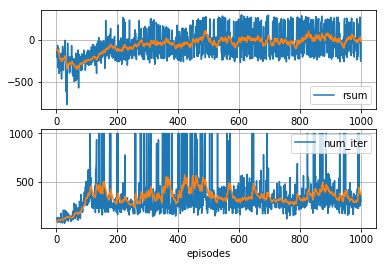

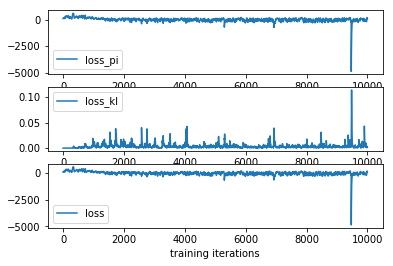

In [34]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.9))
    plt.grid()
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()




In [55]:
## Clipped PPO

gamma = .9999

layers_pi = [20, 20]
layers_V  = [20, 20]
lr_pi = 1e-3
lr_V  = 1e-3

K = 3
eps = .2

obs0 = env.reset()
agent = ClippedPPOAgent(
    action_space=env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi, lr_V=lr_V,
    gamma=gamma,
    K=K, eps=eps,
    env_methods=env_methods,
)




out = train_agent(agent, env, max_iter=500, verbose=1, num_episodes=1500)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=70	DONE    	rsum=-102.44040179032197
Episode 2	num_iter=105	DONE    	rsum=-283.2128219354978
Episode 3	num_iter=64	DONE    	rsum=-90.23622079933865
Episode 4	num_iter=73	DONE    	rsum=-191.45738873190345
Episode 5	num_iter=107	DONE    	rsum=-458.3254701893484
Episode 6	num_iter=76	DONE    	rsum=-250.25554373553126
Episode 7	num_iter=74	DONE    	rsum=-82.93503101465708
Episode 8	num_iter=60	DONE    	rsum=-141.25443910186308
Episode 9	num_iter=78	DONE    	rsum=-325.92129278461186
Episode 10	num_iter=93	DONE    	rsum=-460.60032736053955
Episode 11	num_iter=99	DONE    	rsum=-124.65403189489717
Episode 12	num_iter=64	DONE    	rsum=-119.60491032373876
Episode 13	num_iter=91	DONE    	rsum=-252.40851544287003
Episode 14	num_iter=87	DONE    	rsum=-121.90268639758945
Episode 15	num_iter=81	DONE    	rsum=-261.61228299546156
Episode 16	num_iter=71	DONE    	rsum=-222.10382952637656
Episode 17	num_iter=65	DONE    	rsum=-122.52763808860283
Episode 18	num_iter=100	DONE    	rsum=-201

Episode 146	num_iter=116	DONE    	rsum=-321.9404515030808
Episode 147	num_iter=150	DONE    	rsum=-309.32423056666323
Episode 148	num_iter=115	DONE    	rsum=-120.96230408134078
Episode 149	num_iter=104	DONE    	rsum=-236.10762878403239
Episode 150	num_iter=103	DONE    	rsum=-115.25947484866684
Episode 151	num_iter=98	DONE    	rsum=-209.99410238953894
Episode 152	num_iter=111	DONE    	rsum=-305.53492099481923
Episode 153	num_iter=164	DONE    	rsum=-161.43999017831462
Episode 154	num_iter=107	DONE    	rsum=-348.04773015564695
Episode 155	num_iter=98	DONE    	rsum=-210.04929021732644
Episode 156	num_iter=96	DONE    	rsum=-78.68415792888123
Episode 157	num_iter=103	DONE    	rsum=-268.1875881342244
Episode 158	num_iter=118	DONE    	rsum=-194.3441757346926
Episode 159	num_iter=85	DONE    	rsum=-269.9872511033662
Episode 160	num_iter=85	DONE    	rsum=-293.47252694495364
Episode 161	num_iter=89	DONE    	rsum=-211.88108769994105
Episode 162	num_iter=113	DONE    	rsum=-143.26315316456967
Episode 

Episode 288	num_iter=154	DONE    	rsum=-544.1813295856693
Episode 289	num_iter=118	DONE    	rsum=-241.9638506264402
Episode 290	num_iter=204	DONE    	rsum=-511.041379024539
Episode 291	num_iter=154	DONE    	rsum=-339.40416898562876
Episode 292	num_iter=154	DONE    	rsum=-500.8659140542977
Episode 293	num_iter=101	DONE    	rsum=-161.61302066899148
Episode 294	num_iter=173	DONE    	rsum=-108.50602681384973
Episode 295	num_iter=137	DONE    	rsum=-312.02344531265487
Episode 296	num_iter=174	DONE    	rsum=-546.9007055522725
Episode 297	num_iter=115	DONE    	rsum=-376.6502272805532
Episode 298	num_iter=123	DONE    	rsum=-130.69547301880837
Episode 299	num_iter=112	DONE    	rsum=-313.8463266413955
Episode 300	num_iter=119	DONE    	rsum=-287.1827739383321
Episode 301	num_iter=211	DONE    	rsum=-297.5857093927097
Episode 302	num_iter=94	DONE    	rsum=-388.88720569860374
Episode 303	num_iter=124	DONE    	rsum=-424.2025232208311
Episode 304	num_iter=103	DONE    	rsum=-94.37637560731778
Episode 30

Episode 429	num_iter=336	DONE    	rsum=-17.317899182173804
Episode 430	num_iter=355	DONE    	rsum=-238.89157510064172
Episode 431	num_iter=500	MAX_ITER	rsum=-156.60701283895182
Episode 432	num_iter=236	DONE    	rsum=-223.37208993585983
Episode 433	num_iter=290	DONE    	rsum=-275.92741889780723
Episode 434	num_iter=371	DONE    	rsum=-74.91951891252859
Episode 435	num_iter=250	DONE    	rsum=-298.5670332904706
Episode 436	num_iter=317	DONE    	rsum=-210.37837721313502
Episode 437	num_iter=375	DONE    	rsum=-191.07295329650202
Episode 438	num_iter=295	DONE    	rsum=-185.02851870215153
Episode 439	num_iter=287	DONE    	rsum=-261.7609734789704
Episode 440	num_iter=500	MAX_ITER	rsum=-18.194188754435352
Episode 441	num_iter=393	DONE    	rsum=-280.0077539472011
Episode 442	num_iter=213	DONE    	rsum=-178.16573213003988
Episode 443	num_iter=384	DONE    	rsum=-199.91052892570474
Episode 444	num_iter=291	DONE    	rsum=-27.830368099964602
Episode 445	num_iter=365	DONE    	rsum=-347.84688061624246
E

Episode 570	num_iter=301	DONE    	rsum=-58.8774699865138
Episode 571	num_iter=263	DONE    	rsum=-14.891324271055296
Episode 572	num_iter=297	DONE    	rsum=-311.0017210697116
Episode 573	num_iter=201	DONE    	rsum=-102.99320135800092
Episode 574	num_iter=500	MAX_ITER	rsum=-221.0980564645386
Episode 575	num_iter=256	DONE    	rsum=-241.33951683293785
Episode 576	num_iter=309	DONE    	rsum=-198.41780751110207
Episode 577	num_iter=417	DONE    	rsum=-202.91548969932842
Episode 578	num_iter=256	DONE    	rsum=-102.70601702060031
Episode 579	num_iter=361	DONE    	rsum=-249.31398207859564
Episode 580	num_iter=324	DONE    	rsum=-185.2306671903709
Episode 581	num_iter=292	DONE    	rsum=-213.98410608786668
Episode 582	num_iter=294	DONE    	rsum=-221.28871514807918
Episode 583	num_iter=249	DONE    	rsum=-189.68763459720026
Episode 584	num_iter=252	DONE    	rsum=-196.4128478563503
Episode 585	num_iter=500	MAX_ITER	rsum=-7.2002389349124645
Episode 586	num_iter=347	DONE    	rsum=-58.93737794524557
Epis

Episode 711	num_iter=437	DONE    	rsum=-211.11936415246743
Episode 712	num_iter=267	DONE    	rsum=-257.8726992459931
Episode 713	num_iter=422	DONE    	rsum=-197.49862627596474
Episode 714	num_iter=500	MAX_ITER	rsum=-13.745488455696094
Episode 715	num_iter=500	MAX_ITER	rsum=-2.3467506366819437
Episode 716	num_iter=309	DONE    	rsum=-217.8272881789888
Episode 717	num_iter=395	DONE    	rsum=-32.667008873280935
Episode 718	num_iter=500	MAX_ITER	rsum=-44.47390192040176
Episode 719	num_iter=264	DONE    	rsum=-66.02878457758473
Episode 720	num_iter=458	DONE    	rsum=-219.11347853854807
Episode 721	num_iter=312	DONE    	rsum=-186.50983066647166
Episode 722	num_iter=380	DONE    	rsum=-206.42429307760023
Episode 723	num_iter=487	DONE    	rsum=-252.42022790459552
Episode 724	num_iter=500	MAX_ITER	rsum=-162.04627204160997
Episode 725	num_iter=374	DONE    	rsum=-257.68523644839337
Episode 726	num_iter=500	MAX_ITER	rsum=-49.3560312514909
Episode 727	num_iter=386	DONE    	rsum=-224.4220914510319
Epis

Episode 852	num_iter=324	DONE    	rsum=-175.78682979136673
Episode 853	num_iter=351	DONE    	rsum=-176.31990646283577
Episode 854	num_iter=500	MAX_ITER	rsum=76.09701552268488
Episode 855	num_iter=500	MAX_ITER	rsum=106.80069228614006
Episode 856	num_iter=500	MAX_ITER	rsum=-94.2386307351876
Episode 857	num_iter=500	MAX_ITER	rsum=68.42675012283674
Episode 858	num_iter=344	DONE    	rsum=-210.79525500220637
Episode 859	num_iter=500	MAX_ITER	rsum=58.37022343824411
Episode 860	num_iter=363	DONE    	rsum=-58.451715049861264
Episode 861	num_iter=357	DONE    	rsum=-233.76041134446976
Episode 862	num_iter=448	DONE    	rsum=-238.1465732652959
Episode 863	num_iter=375	DONE    	rsum=-247.4053172450091
Episode 864	num_iter=430	DONE    	rsum=-99.7516500579963
Episode 865	num_iter=500	MAX_ITER	rsum=-61.009781326222495
Episode 866	num_iter=293	DONE    	rsum=-139.47976592889086
Episode 867	num_iter=500	MAX_ITER	rsum=53.41377819819557
Episode 868	num_iter=376	DONE    	rsum=-226.0078044742305
Episode 869	n

Episode 993	num_iter=500	MAX_ITER	rsum=62.05874585801835
Episode 994	num_iter=500	MAX_ITER	rsum=97.06394975289226
Episode 995	num_iter=272	DONE    	rsum=-15.315830693889993
Episode 996	num_iter=251	DONE    	rsum=-6.68961356144159
Episode 997	num_iter=391	DONE    	rsum=-212.55103876320925
Episode 998	num_iter=333	DONE    	rsum=-55.077818309707745
Episode 999	num_iter=448	DONE    	rsum=-281.0797299819974
Episode 1000	num_iter=254	DONE    	rsum=-65.51466308924451
Episode 1001	num_iter=500	MAX_ITER	rsum=121.56570905543492
Episode 1002	num_iter=407	DONE    	rsum=-241.70190083578836
Episode 1003	num_iter=409	DONE    	rsum=-237.1128035586171
Episode 1004	num_iter=500	MAX_ITER	rsum=-158.07696219938137
Episode 1005	num_iter=429	DONE    	rsum=-244.5796364112142
Episode 1006	num_iter=463	DONE    	rsum=-64.00657630230526
Episode 1007	num_iter=330	DONE    	rsum=-212.43283567798358
Episode 1008	num_iter=290	DONE    	rsum=-218.35162032053933
Episode 1009	num_iter=500	MAX_ITER	rsum=-72.22655953969367


Episode 1132	num_iter=378	DONE    	rsum=-217.20620430751097
Episode 1133	num_iter=408	DONE    	rsum=-202.73571132874122
Episode 1134	num_iter=343	DONE    	rsum=-190.38281674180269
Episode 1135	num_iter=382	DONE    	rsum=-175.29555871492107
Episode 1136	num_iter=499	DONE    	rsum=-243.2338938888521
Episode 1137	num_iter=268	DONE    	rsum=-73.83333595636138
Episode 1138	num_iter=500	MAX_ITER	rsum=-65.8743252212339
Episode 1139	num_iter=438	DONE    	rsum=-204.11564972491172
Episode 1140	num_iter=308	DONE    	rsum=-165.38602080444468
Episode 1141	num_iter=337	DONE    	rsum=-43.331595397643596
Episode 1142	num_iter=372	DONE    	rsum=-235.08293368868394
Episode 1143	num_iter=500	MAX_ITER	rsum=7.421741611411323
Episode 1144	num_iter=307	DONE    	rsum=-197.8683872773729
Episode 1145	num_iter=500	MAX_ITER	rsum=93.18431805644897
Episode 1146	num_iter=435	DONE    	rsum=-252.17635979888496
Episode 1147	num_iter=339	DONE    	rsum=-191.7032343855979
Episode 1148	num_iter=265	DONE    	rsum=-180.82886

Episode 1271	num_iter=331	DONE    	rsum=-57.697342913712646
Episode 1272	num_iter=500	MAX_ITER	rsum=68.12306331910293
Episode 1273	num_iter=500	MAX_ITER	rsum=101.10406099738817
Episode 1274	num_iter=390	DONE    	rsum=-88.85927013892513
Episode 1275	num_iter=500	MAX_ITER	rsum=134.1235715027447
Episode 1276	num_iter=348	DONE    	rsum=-100.5134291034074
Episode 1277	num_iter=379	DONE    	rsum=-68.6991254795377
Episode 1278	num_iter=500	MAX_ITER	rsum=10.51106365734195
Episode 1279	num_iter=281	DONE    	rsum=-49.35173042248938
Episode 1280	num_iter=403	DONE    	rsum=-295.1870358630588
Episode 1281	num_iter=332	DONE    	rsum=-190.2528365795213
Episode 1282	num_iter=500	MAX_ITER	rsum=63.02693130330594
Episode 1283	num_iter=500	MAX_ITER	rsum=88.00405295946987
Episode 1284	num_iter=481	DONE    	rsum=-78.8412688267539
Episode 1285	num_iter=286	DONE    	rsum=-155.342682480224
Episode 1286	num_iter=344	DONE    	rsum=-155.44399623945816
Episode 1287	num_iter=298	DONE    	rsum=-181.85986251333173
Ep

Episode 1410	num_iter=500	MAX_ITER	rsum=101.38891382983594
Episode 1411	num_iter=390	DONE    	rsum=-194.69095768511147
Episode 1412	num_iter=434	DONE    	rsum=-244.68052955138103
Episode 1413	num_iter=484	DONE    	rsum=-269.9352950998047
Episode 1414	num_iter=333	DONE    	rsum=-47.53248017070764
Episode 1415	num_iter=369	DONE    	rsum=-178.29826702539606
Episode 1416	num_iter=469	DONE    	rsum=141.09294367856464
Episode 1417	num_iter=478	DONE    	rsum=-69.47435730652403
Episode 1418	num_iter=348	DONE    	rsum=-18.472742480536013
Episode 1419	num_iter=253	DONE    	rsum=-12.241315723708553
Episode 1420	num_iter=297	DONE    	rsum=-175.33893026512328
Episode 1421	num_iter=322	DONE    	rsum=-199.5131894046272
Episode 1422	num_iter=446	DONE    	rsum=-253.7382589653643
Episode 1423	num_iter=500	MAX_ITER	rsum=10.355003970035686
Episode 1424	num_iter=411	DONE    	rsum=-208.23639521143986
Episode 1425	num_iter=500	MAX_ITER	rsum=121.43831809069482
Episode 1426	num_iter=337	DONE    	rsum=-99.95009

(-217.99506313414733, 311, True)

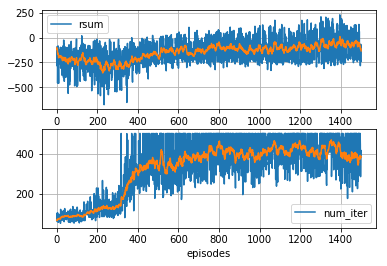

In [56]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.9))
    plt.grid()
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.9), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()




## GridWorld

In [40]:
env_methods = GridWorldFeaturesMethods()
env = gym.make(env_methods.get_env_name())

plan_num = 1
plan_rewards = {0:-0.001, 3:1, 4:1, 5:-1, 6:-1}
env.setPlan("gridworldPlans/plan{}.txt".format(plan_num), plan_rewards)


env_name = 'gridworld-v0'
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 4 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n']


In [46]:
## KL PPO

gamma = .999

layers_pi = [20, 20]
layers_V  = [20, 20]
lr_pi = 1e-3
lr_V  = 1e-3

K = 10
initial_penalty = 1
delta = .1

obs0 = env.reset()
agent = KL_PPOAgent(
    action_space=env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi,
    gamma=gamma,
    initial_penalty=initial_penalty, K=K, delta=delta,
    env_methods=env_methods,
    )


out = train_agent(agent, env, max_iter=20, verbose=1, num_episodes=500)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=6	DONE    	rsum=-1.005
Episode 2	num_iter=1	DONE    	rsum=-1
Episode 3	num_iter=1	DONE    	rsum=-1
Episode 4	num_iter=8	DONE    	rsum=1.994
Episode 5	num_iter=10	DONE    	rsum=1.992
Episode 6	num_iter=1	DONE    	rsum=-1
Episode 7	num_iter=1	DONE    	rsum=-1
Episode 8	num_iter=2	DONE    	rsum=-1.001
Episode 9	num_iter=2	DONE    	rsum=-1.001
Episode 10	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 11	num_iter=14	DONE    	rsum=-0.01200000000000001
Episode 12	num_iter=2	DONE    	rsum=-1.001
Episode 13	num_iter=10	DONE    	rsum=1.992
Episode 14	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 15	num_iter=8	DONE    	rsum=1.994
Episode 16	num_iter=7	DONE    	rsum=-1.006
Episode 17	num_iter=8	DONE    	rsum=-0.006000000000000005
Episode 18	num_iter=6	DONE    	rsum=-1.005
Episode 19	num_iter=10	DONE    	rsum=-0.008000000000000007
Episode 20	num_iter=1	DONE    	rsum=-1
Episode 21	num_iter=1	DONE    	rsum=-1
Episode 22	num_iter=4	DONE    	rsum=1.998
Episode 23	num

RuntimeError: invalid argument 2: invalid multinomial distribution (encountering probability entry < 0) at /tmp/pip-req-build-58y_cjjl/aten/src/TH/generic/THTensorRandom.cpp:356

In [ ]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.95))
    plt.legend()
    plt.grid()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.999), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()



In [47]:
## Clipped PPO

gamma = .9999

layers_pi = [20, 20]
layers_V  = [20, 20]
lr_pi = 1e-3
lr_V  = 1e-3

K = 10
eps = .1

obs0 = env.reset()
agent = ClippedPPOAgent(
    action_space=env.action_space,
    obs0=obs0,
    layers_pi=layers_pi, layers_V=layers_V,
    lr_pi=lr_pi, lr_V=lr_V,
    gamma=gamma,
    K=K, eps=eps,
    env_methods=env_methods,
)




out = train_agent(agent, env, max_iter=20, verbose=1, num_episodes=1500)
play_one_run(agent, env, verbose=2)


Episode 1	num_iter=20	MAX_ITER	rsum=0.981
Episode 2	num_iter=20	MAX_ITER	rsum=-0.02000000000000001
Episode 3	num_iter=3	DONE    	rsum=-1.002
Episode 4	num_iter=6	DONE    	rsum=-1.005
Episode 5	num_iter=20	MAX_ITER	rsum=0.981
Episode 6	num_iter=3	DONE    	rsum=-1.002
Episode 7	num_iter=1	DONE    	rsum=-1
Episode 8	num_iter=1	DONE    	rsum=-1
Episode 9	num_iter=4	DONE    	rsum=-0.0020000000000000018
Episode 10	num_iter=1	DONE    	rsum=-1
Episode 11	num_iter=11	DONE    	rsum=-0.009000000000000008
Episode 12	num_iter=2	DONE    	rsum=-1.001
Episode 13	num_iter=3	DONE    	rsum=-1.002
Episode 14	num_iter=20	MAX_ITER	rsum=-0.018000000000000016
Episode 15	num_iter=16	DONE    	rsum=-0.014000000000000012
Episode 16	num_iter=19	DONE    	rsum=0.982
Episode 17	num_iter=6	DONE    	rsum=-1.005
Episode 18	num_iter=2	DONE    	rsum=-1.001
Episode 19	num_iter=4	DONE    	rsum=1.998
Episode 20	num_iter=3	DONE    	rsum=-1.002
Episode 21	num_iter=4	DONE    	rsum=-1.003
Episode 22	num_iter=20	MAX_ITER	rsum=-0.

RuntimeError: invalid argument 2: invalid multinomial distribution (encountering probability entry < 0) at /tmp/pip-req-build-58y_cjjl/aten/src/TH/generic/THTensorRandom.cpp:356

ValueError: not enough values to unpack (expected 2, got 0)

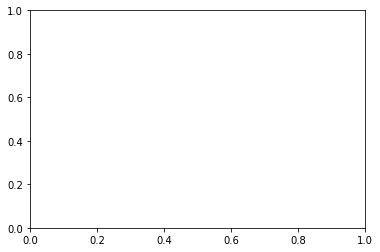

In [69]:
## Plot training log :
keys = ['rsum', 'num_iter']
val_dict = out
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, y, label=k)
    plt.plot(x, smooth(y, 0.9))
    plt.legend()
plt.xlabel("episodes")
plt.show()


## Plot agent log:
val_dict = agent.log_dict
keys = val_dict.keys()
fig = plt.figure()
for i,k in enumerate(keys):
    fig.add_subplot(len(keys), 1, i+1)
    x, y = zip(*val_dict[k])
    plt.plot(x, smooth(y, 0.999), label=k)
    plt.legend()
#     plt.xlim(1000, 1500)
plt.xlabel("training iterations")
plt.show()
